In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
sns.set()

import numpy as np
import pandas as pd
import util
N = 100
df = util.h5_to_df("/bigdata/shared/HepSIM/combo/pythia8_higgs_2_combo.h5")
params = ['Px','Py', 'Pz', 'PT', 'E', 'D0', 'DZ', 'X', 'Y',  'Z', 'T', 'count']
training, target = util.df_to_target(df, output = None, params = params, max_len = N)
training = np.einsum('ijk->ikj', training)
target.shape

Welcome to ROOTaaS 6.06/04
reading file
Generate dictionary
['H', 'W+', 'Z', 'b', 'b', 'c', 'c'] 0
['H', 'W+', 'Z', 'b', 'b', 'c'] 0
['H', 'W+', 'Z', 'b', 'b', 's', 's'] 0
['H', 'W+', 'Z', 'b', 'b', 's'] 0
['H', 'W+', 'Z', 'b', 'b', 't'] 0
['H', 'W+', 'Z', 'b', 'b'] 0
['H', 'W+', 'Z', 'b'] 0
['H', 'W+', 'Z', 'c', 'c'] 0
['H', 'W+', 'Z', 'c'] 0
['H', 'W+', 'Z', 's', 's'] 0
['H', 'W+', 'Z', 's'] 0
['H', 'W+', 'Z', 't'] 0
['H', 'W+', 'Z'] 0
['H', 'W+', 'b', 'b', 'c', 'c', 't'] 0
['H', 'W+', 'b', 'b', 'c', 'c'] 0
['H', 'W+', 'b', 'b', 'c', 's'] 0
['H', 'W+', 'b', 'b', 'c', 't'] 0
['H', 'W+', 'b', 'b', 'c'] 0
['H', 'W+', 'b', 'b', 's', 's', 't'] 0
['H', 'W+', 'b', 'b', 's', 's'] 0
['H', 'W+', 'b', 'b', 's', 't'] 0
['H', 'W+', 'b', 'b', 's'] 0
['H', 'W+', 'b', 'b', 't'] 0
['H', 'W+', 'b', 'b'] 0
['H', 'W+', 'b', 't'] 0
['H', 'W+', 'b'] 0
['H', 'W+', 'c', 'c', 's', 's'] 0
['H', 'W+', 'c', 'c', 's'] 0
['H', 'W+', 'c', 'c'] 0
['H', 'W+', 'c', 's', 's'] 0
['H', 'W+', 'c', 's'] 0
['H', 'W+', 'c']

util.py:359: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  l = np.zeros(length)


(1490621, 5)

Error in <TUnixSystem::FindDynamicLibrary>: libDelphes[.so | .dll | .dylib | .sl | .dl | .a] does not exist in /usr/local/root/lib:/home/avikar/promc/promc/lib:/home/avikar/promc/promc/lib:/usr/local/cuda/targets/x86_64-linux/lib/:.:/usr/local/root/lib:/lib/x86_64-linux-gnu/tls/x86_64:/lib/x86_64-linux-gnu/tls:/lib/x86_64-linux-gnu/x86_64:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu/tls/x86_64:/usr/lib/x86_64-linux-gnu/tls:/usr/lib/x86_64-linux-gnu/x86_64:/usr/lib/x86_64-linux-gnu:/lib/tls/x86_64:/lib/tls:/lib/x86_64:/lib:/usr/lib/tls/x86_64:/usr/lib/tls:/usr/lib/x86_64:/usr/lib
input_line_34:1:10: fatal error: 'classes/DelphesClasses.h' file not found
#include "classes/DelphesClasses.h"
         ^
input_line_35:1:10: fatal error: 'external/ExRootAnalysis/ExRootTreeReader.h' file not found
#include "external/ExRootAnalysis/ExRootTreeReader.h"
         ^
input_line_36:1:10: fatal error: 'external/ExRootAnalysis/ExRootResult.h' file not found
#include "external/ExRootAnalysis/ExRootRe

In [3]:
def get_sample(training, target, choice):
    target_vals = np.argmax(target, axis = 1)
    ind, = np.where(target_vals == choice)
    chosen_ind = np.random.choice(ind, 10000)
    return training[chosen_ind], target[chosen_ind]

n_targets = target.shape[1]
samples = [get_sample(training, target, i) for i in range(n_targets)]
trainings = [i[0] for i in samples]
targets = [i[1] for i in samples]
big_training = np.concatenate(trainings)
big_target = np.concatenate(targets)
big_training, big_target = util.shuffle_together(big_training, big_target)


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
sns.set()
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n + 1)

def predicted_histogram(data, 
                        target, 
                        labels = None, 
                        nbins = 10, 
                        out = None,
                        xlabel = None,
                        title = None
                       ):
    """@params:
        data = n x 1 array of parameter values
        target = n x categories array of predictions
    """
    target = preprocessing.normalize(target, norm = "l1")
    if labels == None:
        labels = ["" for i in range(target.shape[1])]
    #1 decide bins
    ma = np.amax(data) * 1.0
    mi = np.amin(data)
    bins = np.linspace(mi, ma, nbins)
    bin_size = bins[1] - bins[0]
    bin_locs = np.digitize(data, bins, right = True)
    #2 set up bin x category matrix
    #  Each M(bin, category) = Sum over particles with param in bin of category
    M = np.array([np.sum(target[np.where(bin_locs == i)], axis = 0) 
                  for i in range(nbins)])
    #3 plot each category/bin
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    bars = np.array([M[:, i] for i in range(M.shape[1])])
    cmap = get_cmap(len(bars), 'viridis')
    for i in range(len(bars)):
        ax.bar(bins, bars[i], 
               bottom = sum(bars[:i]), 
               color = cmap(i), 
               label = labels[i],
               width = bin_size
              )
    ax.set_xlabel(xlabel)
    ax.set_yticks([])
    ax.set_title(title)
    ax.set_ylabel('log(Frequency)')
    ax.set_yscale('log')
    ax.set_yticks([])
    ax.set_axis_bgcolor("w")
    ax.legend()

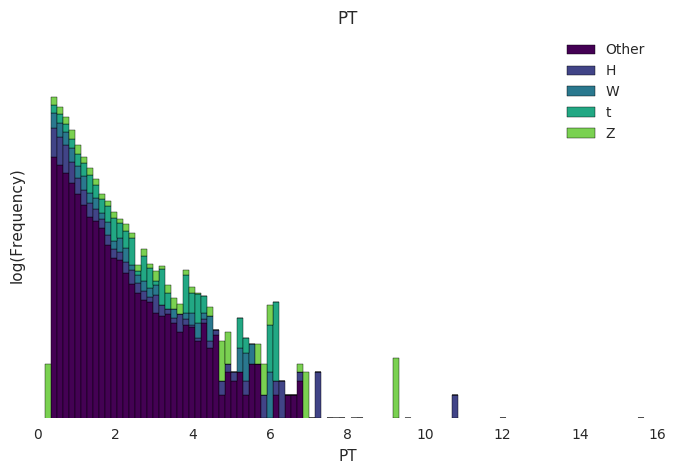

In [37]:
i = 3
sns.set()
predicted_histogram(np.mean(big_training[:, i, :], axis = 1), 
                    big_target, 
                    labels = ['Other', 'H', 'W', 't', 'Z'], 
                    nbins = 100, 
                    out = None,
                    xlabel = params[i],
                    title = params[i])

In [6]:
big_training.shape

(50000, 12, 100)